In [1]:
using BenchmarkTools, CairoMakie, CliqueTrees, DataFrames, KaHyPar, Metis, OMEinsumContractionOrders, Yao

include("reading_qflex_qasm_yao.jl")
using .YaoQASMReader: yaocircuit_from_qasm

In [2]:
# use a binary search to find the minimum `sc_target`
# for the optimizer `KaHyParBipartite`.
function find_sc_target(circuit)
    n = nqubits(circuit)
    low = 0.0; sc_target = 64.0; high = 128.0
    
    while low < high        
        try
            optimizer = KaHyParBipartite(; sc_target)
            yao2einsum(circuit; initial_state=Dict(zip(1:n, zeros(Int, n))), final_state=Dict(zip(1:n, zeros(Int, n))), optimizer)
            high = sc_target
            sc_target = floor((low + high) / 2.0)
        catch error
            low = sc_target + 1.0
            sc_target = floor((low + high) / 2.0)
        end
    end

    return sc_target
end

# run the `KaHyParBipartite` optimizer
function run0(circuit, sc_target)
    n = nqubits(circuit)
    optimizer = KaHyParBipartite(; sc_target)
    net = yao2einsum(circuit; initial_state=Dict(zip(1:n, zeros(Int, n))), final_state=Dict(zip(1:n, zeros(Int, n))), optimizer)
    complexity = contraction_complexity(net)
    return complexity
end

# run the `ND` optimizer with several hyperparameters,
# returning the best
function run1(circuit)
    n = nqubits(circuit)
    mincomplexity = nothing; minsc = mintc = minrwc = typemax(Float64)
    
    algs = (
        SafeRules(ND(MF(),  METISND())),
        SafeRules(ND(MMD(), METISND())),
        SafeRules(ND(MF(),  KaHyParND())),
        SafeRules(ND(MMD(), KaHyParND())),
    )
    
    for alg in algs
        optimizer = Treewidth(; alg)
        net = yao2einsum(circuit; initial_state=Dict(zip(1:n, zeros(Int, n))), final_state=Dict(zip(1:n, zeros(Int, n))), optimizer)
        complexity = contraction_complexity(net); sc = complexity.sc; tc = complexity.tc; rwc = complexity.rwc
        
        if sc < minsc || (sc == minsc && tc < mintc) || (sc == minsc && tc == mintc && rwc < minrwc)
            mincomplexity, minsc, mintc, minrwc = complexity, sc, tc, rwc
        end
    end
    
    return mincomplexity
end

run1 (generic function with 1 method)

In [3]:
file = "bristlecone_48_1-16-1_0.txt"
path = joinpath(@__DIR__, "circuits", file)
circuit = yaocircuit_from_qasm(path)
sc_target = find_sc_target(circuit)
run0(circuit, sc_target)
run1(circuit)

Time complexity: 2^16.020415733445052
Space complexity: 2^11.0
Read-write complexity: 2^15.557433784751453

In [4]:
dataframe = DataFrame(
    sc=Float64[],    # space complexity
    tc=FloatKaHyParBipartitecomplexity
    rwc=Float64[],   # read-write complexity
    time=Float64[],  # run time
    file = String[], # circuit file
    label=Int[],     # label
                     #   - 0: OMEinumContractionOrders
                     #   - 1: CliqueTrees
)

for file in readdir("circuits")
    if endswith(file, ".txt")
        path = joinpath(@__DIR__, "circuits", file)
        circuit = yaocircuit_from_qasm(path)
        sc_target = find_sc_target(circuit)
        
        complexity0 = run0(circuit, sc_target)
        complexity1 = run1(circuit)
        
        time0 = @belapsed run0(circuit, sc_target)
        time1 = @belapsed run1(circuit)
        
        push!(dataframe, (
            complexity0.sc,
            complexity0.tc,
            complexity0.rwc,
            time0,
            file,
            0,
        ))
        
        push!(dataframe, (
            complexity1.sc,
            complexity1.tc,
            complexity1.rwc,
            time1,
            file,
            1,
        ))
        
        println(file)
        println()
        println("OMEinsum")
        println(complexity0)
        println()
        println("CliqueTrees")
        println(complexity1)
        println()
    end
end

bristlecone_48_1-16-1_0.txt

OMEinsum
Time complexity: 2^19.00815776304261
Space complexity: 2^13.0
Read-write complexity: 2^16.609366336335096

CliqueTrees
Time complexity: 2^16.020415733445052
Space complexity: 2^11.0
Read-write complexity: 2^15.557433784751453

bristlecone_48_1-20-1_0.txt

OMEinsum
Time complexity: 2^21.739715107637686
Space complexity: 2^15.0
Read-write complexity: 2^18.712792295874728

CliqueTrees
Time complexity: 2^17.909482955911344
Space complexity: 2^12.0
Read-write complexity: 2^16.84628615579008

bristlecone_48_1-24-1_0.txt

OMEinsum
Time complexity: 2^25.13111375510817
Space complexity: 2^17.0
Read-write complexity: 2^20.701693112254258

CliqueTrees
Time complexity: 2^21.75610426937256
Space complexity: 2^15.0
Read-write complexity: 2^19.878019470813772

bristlecone_48_1-32-1_0.txt

OMEinsum
Time complexity: 2^33.40619667481881
Space complexity: 2^22.0
Read-write complexity: 2^25.48876998484381

CliqueTrees
Time complexity: 2^29.25984338161437
Space complex

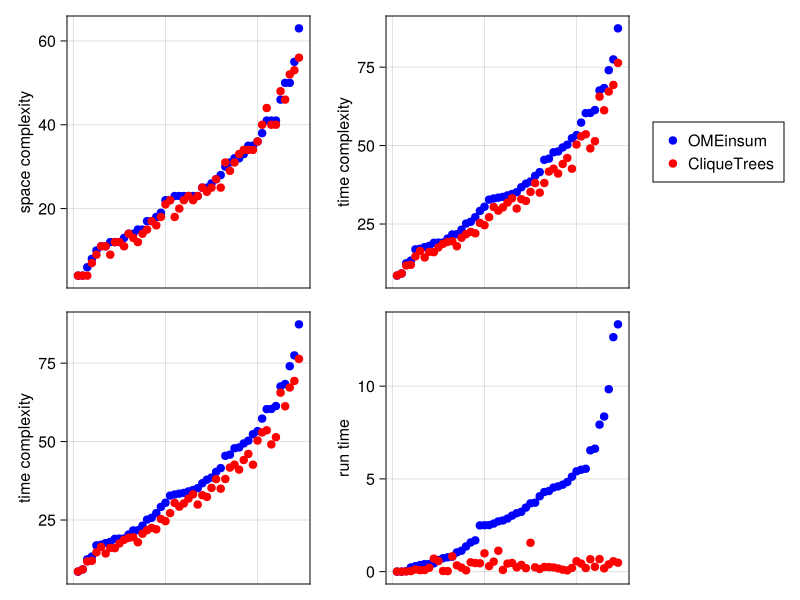

In [6]:
figure = Figure(size = (450, 250))

sc0 = dataframe.sc[dataframe.label .== 0]
sc1 = dataframe.sc[dataframe.label .== 1]
perm = sortperm(sc0)
axis = Axis(figure[1, 1], ylabel = "space complexity", xticksvisible = false, xticklabelsvisible = false)
scatter!(axis, sc0[perm], color = :blue)
scatter!(axis, sc1[perm], color = :red)

tc0 = dataframe.tc[dataframe.label .== 0]
tc1 = dataframe.tc[dataframe.label .== 1]
perm = sortperm(tc0)
axis = Axis(figure[1, 2], ylabel = "time complexity", xticksvisible = false, xticklabelsvisible = false)
scatter!(axis, tc0[perm], color = :blue)
scatter!(axis, tc1[perm], color = :red)

rwc0 = dataframe.tc[dataframe.label .== 0]
rwc1 = dataframe.tc[dataframe.label .== 1]
perm = sortperm(rwc0)
axis = Axis(figure[2, 1], ylabel = "time complexity", xticksvisible = false, xticklabelsvisible = false)
scatter!(axis, rwc0[perm], color = :blue)
scatter!(axis, rwc1[perm], color = :red)

time0 = dataframe.time[dataframe.label .== 0]
time1 = dataframe.time[dataframe.label .== 1]
perm = sortperm(time0)
axis = Axis(figure[2, 2], ylabel = "run time", xticksvisible = false, xticklabelsvisible = false)
plot0 = scatter!(axis, time0[perm], color = :blue)
plot1 = scatter!(axis, time1[perm], color = :red)

Legend(
    figure[1, 3],
    [plot0, plot1],
    ["OMEinsum", "CliqueTrees"]
)

save("figure.png", figure)
figure